# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
#!pip install gymnasium as gym
!pip install gym[box2d]
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
#!python -m pip install pyvirtualdisplay
from pyvirtualdisplay import Display
display = Display(visible=True, size=(1400, 900))
display.start()

  Using cached PyVirtualDisplay-3.0-py3-none-any.whl (15 kB)


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [3]:
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

In [5]:
gym.envs.registry

In [6]:
#from IPython import display
display

<module 'IPython.display' from 'C:\\Users\\David\\.conda\\envs\\drlnd\\lib\\site-packages\\IPython\\display.py'>

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

State shape:  (8,)
Number of actions:  4


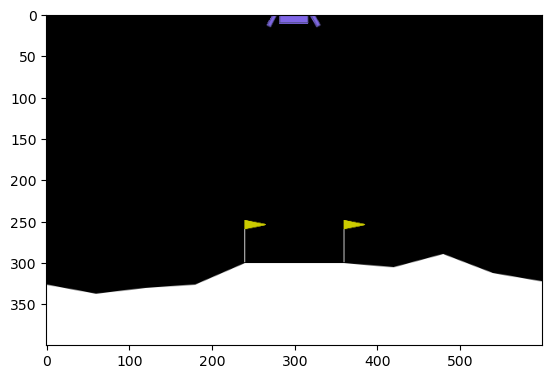

In [7]:
### OLD GYM

env = gym.make("LunarLander-v2", render_mode="rgb_array")
env.seed = 1234
state, info = env.reset()
obs = env.render()
    #,
    #continuous = False, #False
    #gravity = -9.81, #0 and -12
    #enable_wind = True, #False
    #wind_power = 1.5, #0.0 and 20.0
    #turbulence_power = 0.15, #0.0 and 2.0
    #)

state_space = env.observation_space.shape
action_size = env.action_space.n
print('State shape: ', state_space)
print('Number of actions: ', action_size)
plt.imshow(obs)

In [ ]:
print([k for k in gym.envs.registry.env_specs.keys() if "Pong" in k])  #.all().keys()  #.make

In [8]:
#import gym
env = gym.make("LunarLander-v2", options={'continuous': False,
                                          'gravity': -9.81,
                                          'enable_wind': True,
                                          'wind_power': 1.5,
                                          'turbulence_power': 0.15}
              )
env.seed(123)
state, info = env.reset()
obs = env.render()

done = False
while not done:
    action = env.action_space.sample()  # agent policy that uses the observation and info
    state, reward, done, trun, info = env.step(action)
    print(action, reward)
    obs = env.render(mode="rgb_array")
    plt.imshow(obs)

obs_space = env.observation_space.shape
action_size = env.action_space.n
print('State shape: ', obs_space)
print('Number of actions: ', action_size)

TypeError: __init__() got an unexpected keyword argument 'options'

In [9]:
state

array([-0.00213795,  1.404501  , -0.21656592, -0.2852937 ,  0.00248414,
        0.04905533,  0.        ,  0.        ], dtype=float32)

The observation space is an 8-dimensional vector: 
* the coordinates of the lander (x & y), 
* its linear velocities (x & y), 
* its angle (radians), 
* its angular velocity, 
* and two booleans for whether/not each leg has ground contact.

Observation Highs:
* [1.5  1.5  5.0  5.0  3.14  5.0  True  True ]

Observation Lows:
* [-1.5  -1.5  -5.0  -5.0  -3.14  -5.0  False  False ]

Wind function:

tanh(sin(2 k (t+C)) + sin(pi k (t+C))). k is set to 0.01. C is sampled randomly between -9999 and 9999


In [ ]:
##### For gymnasium!
#!pip install gymnasium[box2d]
env = gym.make(
            "LunarLander-v2",
            continuous= False,
            gravity= -9.81,
            enable_wind= True,
            wind_power= 11.1,
            turbulence_power= 1.75,
            render_mode="rgb_array",
            new_step_api=False,
)

print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

Before running the next code cell, familiarize yourself with the code in **Step 2** and **Step 3** of this notebook, along with the code in `dqn_agent.py` and `model.py`.  Once you have an understanding of how the different files work together, 
- Define a neural network architecture in `model.py` that maps states to action values.  This file is mostly empty - it's up to you to define your own deep Q-network!
- Finish the `learn` method in the `Agent` class in `dqn_agent.py`.  The sampled batch of experience tuples is already provided for you; you need only use the local and target Q-networks to compute the loss, before taking a step towards minimizing the loss.

Once you have completed the code in `dqn_agent.py` and `model.py`, run the code cell below.  (_If you end up needing to make multiple changes and get unexpected behavior, please restart the kernel and run the cells from the beginning of the notebook!_)

You can find the solution files, along with saved model weights for a trained agent, in the `solution/` folder.  (_Note that there are many ways to solve this exercise, and the "solution" is just one way of approaching the problem, to yield a trained agent._)

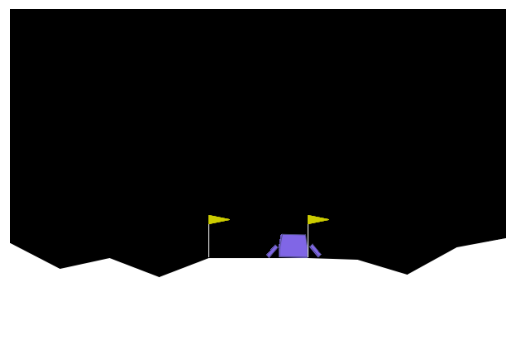

In [10]:
from dqn_agent import Agent

env.seed = 1234
agent = Agent(state_size=state_space[0], action_size=action_size, seed=env.seed)
#agent.qnetwork_local.load_state_dict(torch.load('checkpoint_2k.pth'))

# watch a well-trained agent
state, _ = env.reset()
img = plt.imshow(env.render())
for j in range(200):
    action = agent.act(state)
    state, reward, done,trun, _ = env.step(action)
    img.set_data(env.render()) 
    plt.axis('off')
    display.display(plt.gcf())
    display.clear_output(wait=True)
    if done:
        break 
      
#env.close()

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

In [14]:
import dqn_agent
dqn_agent.device

device(type='cuda', index=0)

In [12]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.99):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    window_size = 100                  # scores to rolling-remember
    scores_window = deque(maxlen=window_size)
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state, _ = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, trun, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")  #\tEpsilon: {:.2f}
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(scores_window), eps))
        if np.mean(scores_window)>=121.0:
            print('\nEnvironment over-solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'highpoint.pth')
            break
        elif np.mean(scores_window)>=100.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')           
    return scores


In [ ]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

In [ ]:
torch.save(agent.qnetwork_local.state_dict(), 'dqn_windypoint.pth')

In [15]:
scores = dqn(n_episodes=500, max_t=200, eps_start=1.0, eps_end=0.01, eps_decay=0.991)

Episode 100	Average Score: -164.01	Epsilon: 0.30
Episode 200	Average Score: -35.41	Epsilon: 0.12
Episode 300	Average Score: -13.26	Epsilon: 0.05
Episode 400	Average Score: 14.47	Epsilon: 0.03
Episode 500	Average Score: 20.76	Epsilon: 0.03


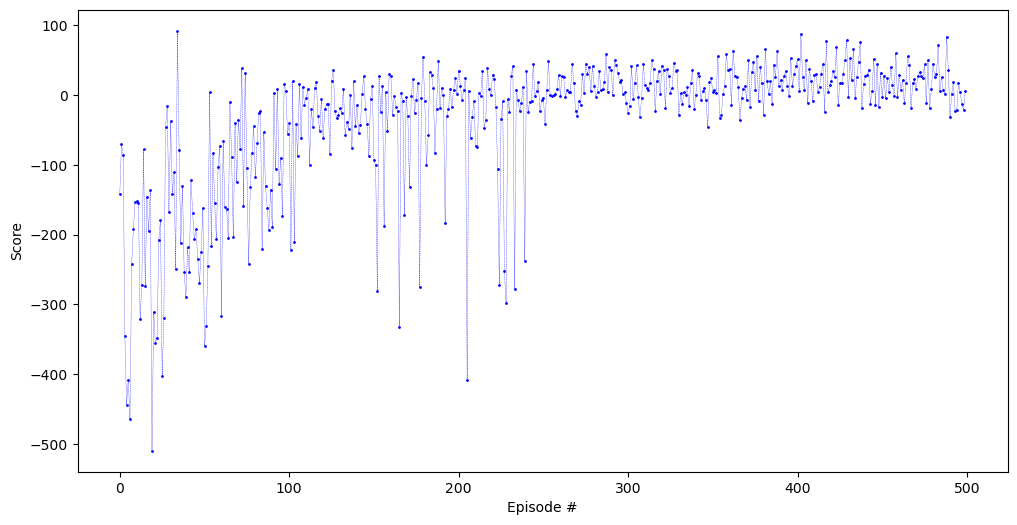

In [16]:
# plot the scores
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, 'bo--', linewidth=0.25, markersize=1.0,)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  